In [1524]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1525]:
monthly_index_info = pd.read_excel('/home/nikhil/Downloads/monthly_info.xlsx')
monthly_index_info['end_idx'] = monthly_index_info['end_idx'] + 1
monthly_index_info.head()

,year,start_idx,end_idx
0,1901,0,12
1,1902,12,24
2,1903,24,36
3,1904,36,48
4,1905,48,60


In [1526]:
locations = pd.read_csv("/home/nikhil/Downloads/NE_lat_long.csv")
locations.head()

,latitude,longitude
0,22.00,93.00
1,22.25,92.50
2,22.25,92.75
3,22.25,93.00
4,22.50,92.50


In [1527]:
def get_closest_index(lat, lon):
    dist = np.sqrt((locations['latitude'] - lat) ** 2 + (locations['longitude'] - lon) ** 2)
    return dist.idxmin()

In [1528]:
# 1. Guwahati 
# 26.1158° N, 91.7086° E

# 2. Imphal 
# 24.8170° N, 93.9368° E

# 3. Agartala
# 23.8315° N, 91.2868° E

# 4. Itanagar
# 27.0844° N, 93.6053° E

guwahati_index = get_closest_index(26.1158, 91.7086)
imphal_index = get_closest_index(24.8170, 93.9368)
agartala_index = get_closest_index(23.8315, 91.2868)
itanagar_index = get_closest_index(27.0844, 93.6053)

guwahati_index, imphal_index, agartala_index, itanagar_index

(161, 83, 31, 253)

In [1529]:
def DMD_Analysis(data,r):
    X = data[:, :-1]
    Xprime = data[:, 1:]
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
    Lambda, W = np.linalg.eig(Atilde) # Step 3
    Lambda = np.diag(Lambda)

    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    return Phi, Lambda, b

In [1530]:
def DMD(data, r):
    X1 = data[:, :-1]
    X2 = data[:, 1:]
    u, s, v = np.linalg.svd(X1, full_matrices = False)
    A_tilde = u[:, : r].conj().T @ X2 @ v[: r, :].conj().T * np.reciprocal(s[: r])
    # print(A_tilde.shape)
    Phi, Q = np.linalg.eig(A_tilde)
    # print(Phi.shape)
    Psi = X2 @ v[: r, :].conj().T @ np.diag(np.reciprocal(s[: r])) @ Q
    # print(Psi.shape)
    A = Psi @ np.diag(Phi) @ np.linalg.pinv(Psi)

    return A_tilde, Phi, A

In [1531]:
def DMD4cast(data, r, pred_step):
    N, T = data.shape
    _, _, A = DMD(data, r)
    mat = np.append(data, np.zeros((N, pred_step)), axis = 1)
    for s in range(pred_step):
        mat[:, T + s] = (A @ mat[:, T + s - 1]).real
    return mat[:, - pred_step :]

In [1532]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Data

In [1533]:
start_year = 2005 #1929 
end_year = 2015 #1939

In [1534]:
# get index from monthly_index_info
def get_index_from_monthly_info(start_year, end_year):
    start_idx = monthly_index_info[monthly_index_info['year'] == start_year]['start_idx'].values[0]
    end_idx = monthly_index_info[monthly_index_info['year'] == end_year]['end_idx'].values[0]
    return start_idx, end_idx

In [1535]:
data = np.load("/home/nikhil/Downloads/1901_2018_monthly.npy")
s,e = get_index_from_monthly_info(start_year, end_year)
data_train = data[:, s:e] # 1929 - 1939
data_train.shape

(435, 132)

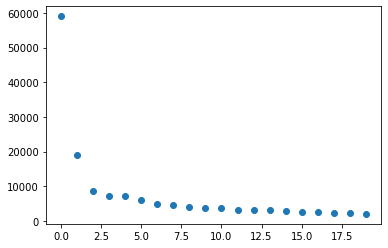

In [1536]:
X = data_train
U,Sigma,VT = np.linalg.svd(X,full_matrices=0) 
plt.scatter(np.arange(20), Sigma[:20])

In [1537]:
max_rank = len(np.where(Sigma > 0.01)[0])
max_rank

130

In [1538]:
def best_results(rank):
    last_year = DMD4cast(data_train, rank, 12*no_of_pred_years)
    true_data = data[:, start_idx:end_idx] 
    rmse = np.sqrt(mean_squared_error(true_data, last_year))
    mae = mean_absolute_error(true_data, last_year)
    return rmse, mae

g_mae = 999
g_rmse = 999
g_i = 0
for i in np.arange(1, max_rank):
    rmse, mae = best_results(i)
    if mae < g_mae:
        g_mae = mae
        g_rmse = rmse
        g_i = i

print(g_i, g_rmse, g_mae)

100 236.38566521245352 124.99981614163033


In [1539]:
rank = g_i
rank

100

# Analysis

In [1540]:
Phi, Lambda, b = DMD_Analysis(data_train, rank)

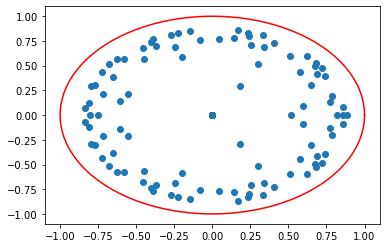

In [1541]:
plt.scatter(np.real(Lambda),np.imag(Lambda))
# draw the unit circle
plt.plot(np.cos(np.linspace(0,2*np.pi,100)),np.sin(np.linspace(0,2*np.pi,100)),color='red')

# Prediction

In [1542]:
no_of_pred_years = 1

In [1543]:
pred_start_year = end_year + 1
pred_end_year = pred_start_year + no_of_pred_years -1

start_idx, end_idx = get_index_from_monthly_info(pred_start_year, pred_end_year)
start_idx, end_idx

(1380, 1392)

In [1544]:
last_year = DMD4cast(data_train, rank, 12*no_of_pred_years)
true_data = data[:, start_idx:end_idx] 

last_year.shape, true_data.shape

((435, 12), (435, 12))

In [1545]:
rmse = np.sqrt(mean_squared_error(true_data, last_year))
mae = mean_absolute_error(true_data, last_year)

# print error rounded to 4 decimal places
print("RMSE: {:.4f}".format(rmse))
print("MAE: {:.4f}".format(mae))


RMSE: 236.3857
MAE: 124.9998


In [1546]:
def make_plots(name, location_index):
    # with title and axis labels
    plt.figure(figsize=(8, 5))
    plt.plot(true_data[location_index, :], label="True")
    plt.plot(last_year[location_index, :], label="Predicted")
    plt.legend()
    plt.title("DMD Forecasting for {}".format(name))
    plt.xlabel("Months")
    plt.ylabel("Rainfall (mm)")
    plt.show()

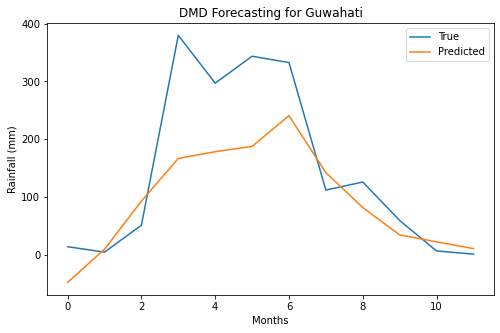

In [1547]:
make_plots("Guwahati" , guwahati_index)

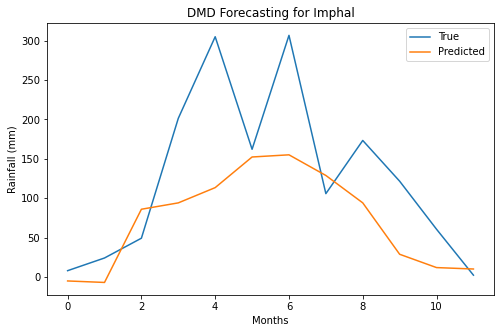

In [1548]:
make_plots("Imphal" , imphal_index)

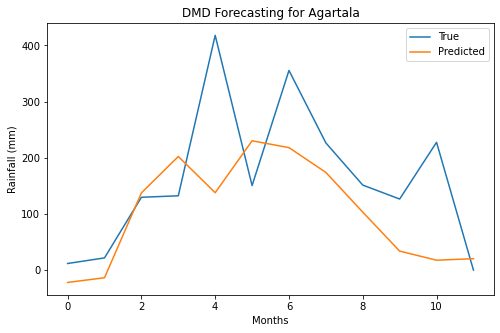

In [1549]:
make_plots("Agartala" , agartala_index)

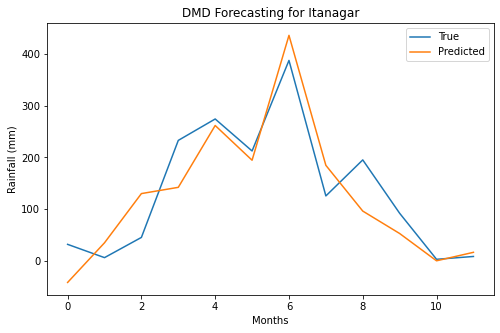

In [1550]:
make_plots("Itanagar" , itanagar_index)